In [221]:
import sys
sys.path.append('../Utils')
import Solve_Slice
from Solve_Slice import find_B, scatter_pies, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
# import numpy as np
# import rpy2.robjects as ro
# from scipy.sparse import csc_matrix

# ro.r['load']('../Data/sc_count.RData')

# i = np.array(ro.r('sc_count@i'), dtype=np.int32)    # row indices (0-based)
# p = np.array(ro.r('sc_count@p'), dtype=np.int32)    # col indptr
# x = np.array(ro.r('sc_count@x'), dtype=float)       # data
# nrow, ncol = map(int, list(ro.r('dim(sc_count)')))

# # Build CSC (matches R's dgCMatrix layout), then convert to CSR if you prefer
# X = csc_matrix((x, i, p), shape=(nrow, ncol)).tocsr()

# genes = [str(s) for s in list(ro.r('rownames(sc_count)'))]
# cells = [str(s) for s in list(ro.r('colnames(sc_count)'))]
# print(X.shape, len(genes), len(cells))


# # ---------- Load metadata (2nd RData) ----------
# import anndata as ad
# import pandas as pd
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import pandas2ri

# # X, genes, cells built above

# # Load metadata RData
# ro.r['load']('../Data/sc_meta.RData')

# # Try to find a cell metadata frame (rownames matching cells)
# cell_meta = None
# for nm in list(ro.r('ls()')):
#     if 'data.frame' in list(ro.r(f'class({nm})')):
#         rn = [str(s) for s in list(ro.r(f'rownames({nm})'))]
#         if set(cells).issubset(set(rn)):
#             with localconverter(ro.default_converter + pandas2ri.converter):
#                 cell_meta = ro.conversion.rpy2py(ro.r[nm]).loc[cells]
#             break
# if cell_meta is None:
#     cell_meta = pd.DataFrame(index=cells)

# # (Optional) gene metadata by matching rownames to genes
# gene_meta = None
# for nm in list(ro.r('ls()')):
#     if 'data.frame' in list(ro.r(f'class({nm})')):
#         rn = [str(s) for s in list(ro.r(f'rownames({nm})'))]
#         if set(genes).issubset(set(rn)):
#             with localconverter(ro.default_converter + pandas2ri.converter):
#                 gene_meta = ro.conversion.rpy2py(ro.r[nm]).loc[genes]
#             break
# if gene_meta is None:
#     gene_meta = pd.DataFrame(index=genes)

# adata = ad.AnnData(X=X.T.tocsr(), obs=cell_meta, var=gene_meta)
# adata.obs_names = cells
# adata.var_names = genes
# # Make var_names unique if needed
# adata.var_names_make_unique()
# adata.write('../Data/sc_data.h5ad')
# print(adata)



In [223]:
adata

AnnData object with n_obs × n_vars = 428 × 25753
    obs: 'x', 'y'
    obsm: 'spatial'

In [224]:

# pip install anndata pandas scipy rpy2
# import numpy as np, pandas as pd, anndata as ad
# import rpy2.robjects as ro
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import pandas2ri
# from scipy.sparse import csc_matrix

# # ---- Load counts ----
# ro.r['load']('../Data/spatial_count.RData')      # contains 'spatial_count' (dgCMatrix)
# i = np.array(ro.r('spatial_count@i'), dtype=np.int32)
# p = np.array(ro.r('spatial_count@p'), dtype=np.int32)
# x = np.array(ro.r('spatial_count@x'), dtype=float)
# nrow, ncol = map(int, list(ro.r('dim(spatial_count)')))
# genes = [str(s) for s in list(ro.r('rownames(spatial_count)'))]
# cells_counts = [str(s) for s in list(ro.r('colnames(spatial_count)'))]

# # R's dgCMatrix is CSC → build CSC then transpose to cells×genes
# X = csc_matrix((x, i, p), shape=(nrow, ncol)).T.tocsr()   # shape: n_cells × n_genes

# # ---- Load locations ----
# ro.r['load']('../Data/spatial_location.RData')   # contains 'spatial_location' (data.frame)
# with localconverter(ro.default_converter + pandas2ri.converter):
#     loc = ro.conversion.rpy2py(ro.r['spatial_location'])

# # Ensure rownames became index; your preview shows x,y columns already:
# # (If rownames didn't carry over for some reason, uncomment the next 2 lines)
# # rn = [str(s) for s in list(ro.r('rownames(spatial_location)'))]
# # loc.index = pd.Index(rn, name='cell')

# # Keep only x,y; ensure numeric
# loc = loc[['x','y']].apply(pd.to_numeric, errors='coerce')
# loc.index.name = 'cell'

# # ---- Align counts to locations by cell/spot IDs ----
# cells_loc = loc.index.astype(str).tolist()

# # Intersect to be safe (drops any non-overlapping spots)
# keep_cells = sorted(set(cells_counts).intersection(cells_loc))
# if not keep_cells:
#     raise RuntimeError("No overlapping spot IDs between counts and locations.")

# # Reorder everything to the same cell order
# order_in_counts = {c:i for i,c in enumerate(cells_counts)}
# idx = np.array([order_in_counts[c] for c in keep_cells], dtype=int)
# X = X[idx, :]                                # subset
# obs = loc.loc[keep_cells].copy()             # x,y per cell
# var = pd.DataFrame(index=pd.Index(genes, name='gene'))

# # ---- Build AnnData ----
# adata = ad.AnnData(X=X, obs=obs, var=var)
# adata.obs_names = keep_cells
# adata.var_names = genes
# adata.var_names_make_unique()

# # Standard slot for spatial coords (n_cells × 2)
# adata.obsm['spatial'] = adata.obs[['x','y']].to_numpy()

# adata.write('spatial.h5ad')
# print(adata)
# print("Stored coordinates in adata.obsm['spatial'] (columns: x, y). Saved to spatial.h5ad.")


In [225]:
import anndata as ad
import pandas as pd
adata = ad.read_h5ad("../Data/sc_data.h5ad")   # replace with your filename
print(adata)
sc.pp.log1p(adata)
# Convert sparse to dense if needed (but stay careful with memory)
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()   # optional; you can also work with sparse

# Create a DataFrame: rows=cells, cols=genes
expr_df = pd.DataFrame(X, index=adata.obs.index, columns=adata.var_names)

# Add cell type column
expr_df['cellType'] = adata.obs['cellType'].values

# Group by cell type and compute mean expression across cells
avg_expr = expr_df.groupby('cellType').mean()

print(avg_expr)
pd_B = avg_expr


AnnData object with n_obs × n_vars = 1926 × 19736
    obs: 'cellID', 'cellType', 'sampleInfo'
                                          A1BG      A1CF       A2M     A2ML1  \
cellType                                                                       
Acinar_cells                          0.053319  0.000000  0.000000  0.000000   
Cancer_clone_A                        0.000000  0.005501  0.000000  0.005501   
Cancer_clone_B                        0.000000  0.000000  0.000000  0.371290   
Ductal_APOL1_high-hypoxic             0.000000  0.063141  0.003224  0.000000   
Ductal_CRISP3_high-centroacinar_like  0.001310  0.102130  0.001310  0.001310   
Ductal_MHC_Class_II                   0.000000  0.094376  0.000000  0.000000   
Ductal_terminal_ductal_like           0.000000  0.051006  0.000000  0.005941   
Endocrine_cells                       0.366204  0.366204  0.000000  0.000000   
Endothelial_cells                     0.000000  0.000000  1.475563  0.000000   
Fibroblasts               

/var/folders/k7/s0t_zwg11h56xb5xp339s5pm0000gp/T/ipykernel_73429/115297159.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_expr = expr_df.groupby('cellType').mean()


In [226]:
adata = ad.read_h5ad("../Data/spatial.h5ad")   # replace with your filename
adata


AnnData object with n_obs × n_vars = 428 × 25753
    obs: 'x', 'y'
    obsm: 'spatial'

In [227]:
adata = ad.read_h5ad("../Data/sc_data.h5ad")
B = find_B(adata)
B.to_numpy().shape

/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_expr = expr_df.groupby('cellType').mean()


(20, 19736)

In [228]:
import scanpy as sc
print(adata)
n_top = 100
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top)

mask = adata.var['highly_variable']
gene_names = adata.var_names[mask]
print(gene_names)
print(pd_B.columns)
# Intersection with B’s index (genes as rows)
common = gene_names.intersection(pd_B.columns)
# print(common)
# Subset AnnData and B, in the same order
adata_sub = adata[:, common].copy()
pd_B_sub = pd_B[common]

print(adata_sub.shape, pd_B_sub.shape)
# adata_sub


AnnData object with n_obs × n_vars = 1926 × 19736
    obs: 'cellID', 'cellType', 'sampleInfo'
    uns: 'log1p'
Index(['ACKR1', 'ADCYAP1', 'ALAS2', 'ALOX5AP', 'AMY1A', 'AMY1B', 'AMY1C',
       'ANGPTL7', 'APOD', 'APOE', 'C1QA', 'C1QB', 'C1QC', 'CCL18', 'CCL21',
       'CCL5', 'CEL', 'CELA2A', 'CELA2B', 'CELA3A', 'CELA3B', 'CHGB', 'CLCA1',
       'CLPS', 'COL10A1', 'COL1A2', 'COL3A1', 'COL6A3', 'CPA1', 'CPA2', 'CPA3',
       'CPA5', 'CPB1', 'CTRB1', 'CTRB2', 'CTRC', 'CUZD1', 'CXCL3', 'CXCR4',
       'FCER1G', 'FGG', 'FOXI1', 'G0S2', 'GATA2', 'GDF15', 'GHRL', 'GNLY',
       'GZMB', 'HBA1', 'HBA2', 'HBB', 'HBD', 'HLA-DPA1', 'HLA-DPB1', 'IGFBP3',
       'IGFBP5', 'KRT16', 'LAPTM5', 'LTF', 'LUM', 'LY6D', 'MGP', 'MMP9',
       'MUC5AC', 'MUC6', 'PI16', 'PLA2G1B', 'PLVAP', 'PNLIP', 'PNLIPRP1',
       'POSTN', 'PPY', 'PRSS1', 'PRSS2', 'PTGS2', 'REG3G', 'REG4', 'RGS1',
       'S100A4', 'S100A8', 'S100A9', 'S100P', 'SAA1', 'SCG2', 'SCGB3A1',
       'SFRP2', 'SLC18A2', 'SPARC', 'SPARCL1', 'SPRR3',

In [229]:
adata = ad.read_h5ad("../Data/spatial.h5ad")
V = solve_V_per_slice(adata, pd_B, lam=0.1)

Index(['AAAS', 'AADAC', 'AAGAB', 'ABCA12', 'ABCA3', 'ABCC8', 'ABHD15', 'ABHD5',
       'ABHD8', 'ABI1P1',
       ...
       'ZNFX1', 'ZPR1', 'ZRANB1', 'ZSCAN18', 'ZSCAN21', 'ZSWIM3', 'ZSWIM7',
       'ZW10', 'ZZEF1', 'snoU109'],
      dtype='object', length=2003)
Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(428, 1558)
(1558, 20)
iter    0  f=4.342904e+04  rel_drop=1.281e-01  step=1.00e-03
iter   50  f=3.539369e+04  rel_drop=1.918e-04  step=1.00e-03
iter   91  f=3.528487e+04  rel_drop=3.022e-10  step=7.63e-09
stopped after iteration # 91
stopped after iteration #91


In [230]:
all_types = pd_B.index.to_list()
all_types

['Acinar_cells',
 'Cancer_clone_A',
 'Cancer_clone_B',
 'Ductal_APOL1_high-hypoxic',
 'Ductal_CRISP3_high-centroacinar_like',
 'Ductal_MHC_Class_II',
 'Ductal_terminal_ductal_like',
 'Endocrine_cells',
 'Endothelial_cells',
 'Fibroblasts',
 'Macrophages_A',
 'Macrophages_B',
 'Mast_cells',
 'Monocytes',
 'RBCs',
 'T_cells_&_NK_cells',
 'Tuft_cells',
 'mDCs_A',
 'mDCs_B',
 'pDCs']

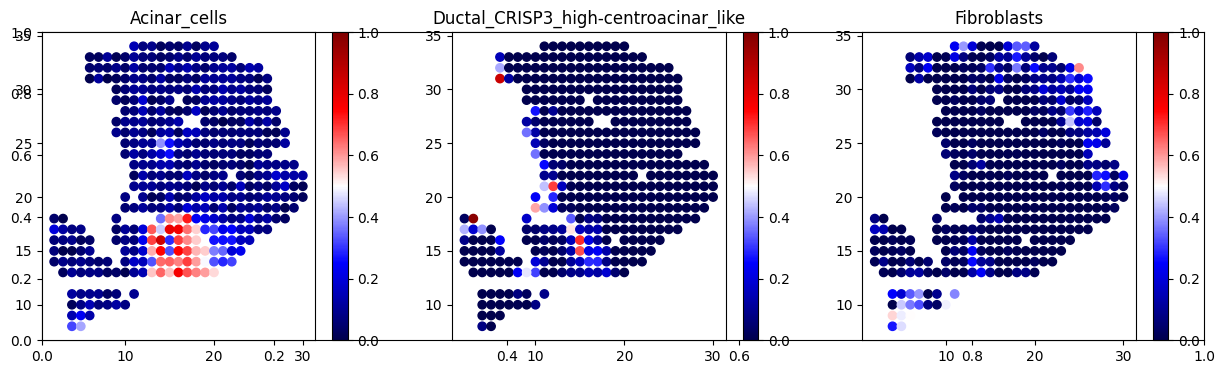

In [231]:
cell_idx = [0,4,9]

plt.subplots(figsize=(15, 4))
for k in range(3):
    plt.subplot(1,3,k+1)

    plt.scatter(adata.obs['x'],adata.obs['y'],c=V[:,cell_idx[k]],cmap='seismic')
    plt.colorbar()
    plt.clim([0,1])
    plt.title(all_types[cell_idx[k]])
plt.show()

KeyboardInterrupt: 

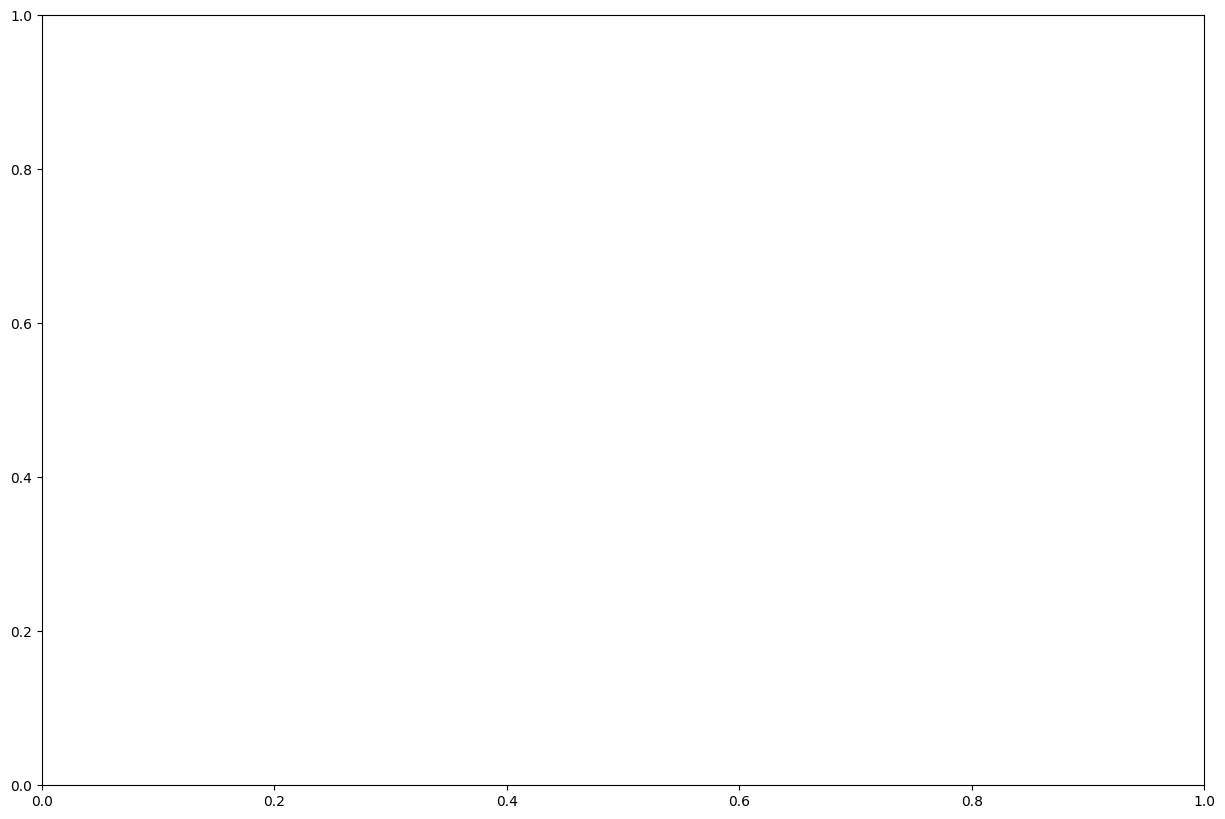

In [232]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

scatter_pies(ax, adata.obs['x'], adata.obs['y'], V, labels=pd_B.index.to_list(),top_n=10)

In [ ]:
adata_group = [adata, adata]
adata = ad.concat(adata_group, axis=0, join="outer", label="batch", keys=['0','1'])
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

mask = adata.var['highly_variable']
gene_names = adata.var_names[mask]
print(gene_names)
print(pd_B.columns)
    # Intersection with B’s index (genes as rows)
common = gene_names.intersection(pd_B.columns)
    # print(common)
    # Subset AnnData and B, in the same order
adata_sub = adata[:, common].copy()
pd_B_sub = pd_B[common]


    


Index(['A1CF', 'A2M', 'AADAC', 'AAGAB', 'AASDH', 'ABCA12', 'ABCA3', 'ABCB7',
       'ABCC8', 'ABHD15',
       ...
       'ZNFX1', 'ZPR1', 'ZRANB1', 'ZSCAN18', 'ZSCAN21', 'ZSCAN25', 'ZSWIM3',
       'ZW10', 'ZZEF1', 'snoU109'],
      dtype='object', length=2000)
Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata

AnnData object with n_obs × n_vars = 856 × 25753
    obs: 'x', 'y', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

def assemble_blocks(diag_blocks, offdiag_blocks=()):
    """
    diag_blocks: list of 2D arrays (dense or sparse), block i has shape (ri, ci)
    offdiag_blocks: iterable of (i, j, Bij) where Bij has shape (ri, cj)

    Returns: CSR sparse matrix with the given diagonal and off-diagonal blocks.
    """
    # sizes per block row/column
    r_sizes = [b.shape[0] for b in diag_blocks]
    c_sizes = [b.shape[1] for b in diag_blocks]

    # total shape
    n_rows = sum(r_sizes)
    n_cols = sum(c_sizes)
    A = lil_matrix((n_rows, n_cols))

    # offsets
    r_off = np.r_[0, np.cumsum(r_sizes[:-1])]
    c_off = np.r_[0, np.cumsum(c_sizes[:-1])]

    # place diagonal blocks
    for i, Bii in enumerate(diag_blocks):
        r0, c0 = r_off[i], c_off[i]
        ri, ci = Bii.shape
        A[r0:r0+ri, c0:c0+ci] = Bii

    # place off-diagonal blocks
    for (i, j, Bij) in offdiag_blocks:
        ri, cj = r_sizes[i], c_sizes[j]
        if Bij.shape != (ri, cj):
            raise ValueError(f"Offdiag block ({i},{j}) must be shape {(ri, cj)}, got {Bij.shape}")
        r0, c0 = r_off[i], c_off[j]
        A[r0:r0+ri, c0:c0+cj] = Bij

    return A.tocsr()


In [ ]:
from scipy.sparse import lil_matrix

L_overall = lil_matrix((adata.obs.shape[0],adata.obs.shape[0]))
n_spots = [0]
for i in range(len(adata_group)):
    n_spots += [n_spots[-1]+adata_group[i].shape[0]]
print(n_spots)


adata = sc.read_h5ad("../Data/spatial.h5ad")
x = adata.obs['x'].to_numpy()
y = adata.obs['y'].to_numpy()

diag_blocks = [0]*2

diag_blocks[0], _ = laplacian_from_coords(x, y, k=20, sigma=None, normed=True)

diag_blocks[1], _ = laplacian_from_coords(x, y, k=20, sigma=None, normed=True)

off_diag_blocks = [ (0,1,np.eye(428)), (1,0,np.eye(428)) ]

L = assemble_blocks(diag_blocks, offdiag_blocks=off_diag_blocks)
L

# x = adata_sub.obs['x'].to_numpy()
# y = adata_sub.obs['y'].to_numpy()

# L, W = laplacian_from_coords(x, y, k=20, sigma=None, normed=True)
# L = lam*L
# B = pd_B_sub.to_numpy().T
# X = adata_sub.X.T

[0, 428, 856]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20608 stored elements and shape (856, 856)>

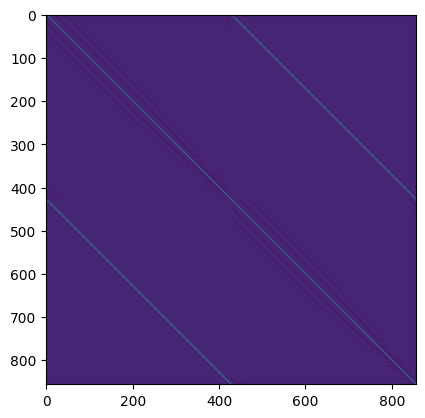

In [ ]:
plt.imshow(L.todense())

In [238]:
def perturb_and_subsample(
    adata, frac=0.5, noise_std=None, dropout_p=None, seed=None
):
    """
    Return a perturbed + subsampled copy of AnnData.
    
    Parameters
    ----------
    adata : AnnData
        Input object.
    frac : float
        Fraction of cells (rows) to keep, 0 < frac <= 1.
    noise_std : float or None
        Std. dev. of Gaussian noise to add to X (if not None).
    dropout_p : float or None
        Dropout probability to set random entries to 0 (if not None).
    seed : int or None
        Random seed for reproducibility.
    """
    rng = np.random.default_rng(seed)

    # --- Subsample rows (cells) ---
    n_obs = adata.n_obs
    n_keep = int(np.ceil(frac * n_obs))
    keep_idx = rng.choice(n_obs, n_keep, replace=False)
    adata_sub = adata[keep_idx].copy()

    # --- Perturb X if requested ---
    X = adata_sub.X
    if hasattr(X, "toarray"):  # convert sparse if needed
        X = X.toarray()

    if noise_std is not None:
        X = X + rng.normal(0, noise_std, size=X.shape)

    if dropout_p is not None:
        mask = rng.random(X.shape) < dropout_p
        X = X.copy()
        X[mask] = 0

    adata_sub.X = X
    adata_sub.uns["perturbation"] = dict(
        noise_std=noise_std, dropout_p=dropout_p, frac=frac
    )
    return adata_sub

adata_noisy = perturb_and_subsample(adata, noise_std=0.1, frac=0.8)
adata_group = [adata, adata_noisy]

In [239]:


V_all, pi = solve_V_all_slices(adata_group, pd_B, mu=0.1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Index(['A2M', 'AARSD1', 'ABBA01006766.1', 'ABCC13', 'ABHD12B', 'ABHD15.AS1',
       'ABHD17AP1', 'ABHD17AP5', 'ABI2', 'AC000081.1',
       ...
       'ZNF708', 'ZNF711', 'ZNF713', 'ZNF726', 'ZNF737', 'ZNF763', 'ZNF790',
       'ZNF969P', 'ZSCAN12', 'uc_338'],
      dtype='object', length=2000)
Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(428, 812)
(812, 20)
iter    0  f=2.646634e+04  rel_drop=3.287e-01  step=1.00e-03
iter   50  f=2.025724e+04  rel_drop=2.811e-04  step=1.00e-03
iter  100  f=2.014206e+04  rel_drop=3.398e-05  step=1.00e-03
iter  104  f=2.014004e+04  rel_drop=7.081e-06  step=2.50e-04
stopped after iteration # 104
stopped after iteration #104
(343, 812)
(812, 20)
iter    0  f=2.356159e+04  rel_drop=3.094e-01  step=1.00e-03
iter   50  f=1.864674e+04  rel_drop=2.493e-04  st

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(771, 812)
(812, 20)
iter    0  f=2.772588e+04  rel_drop=2.029e-01  step=1.00e-03
iter   50  f=1.596638e+04  rel_drop=9.050e-04  step=1.00e-03
iter  100  f=1.565513e+04  rel_drop=1.531e-04  step=1.00e-03
iter  150  f=1.561130e+04  rel_drop=1.343e-05  step=1.00e-03
iter  157  f=1.561008e+04  rel_drop=9.593e-06  step=1.00e-03
stopped after iteration # 157
stopped after iteration #157
iter    0  f=1.561008e+04  rel_drop=3.329e-01
(771, 812)
(812, 20)
iter    0  f=2.772588e+04  rel_drop=2.029e-01  step=1.00e-03
iter   50  f=1.596641e+04  rel_drop=9.050e-04  step=1.00e-03
iter  100  f=1.565517e+04  rel_drop=1.531e-04  step=1.00e-03
iter  150  f=1.561133e+04  rel_drop=1.343e-05  step=1.00e-03
iter  157  f=1.561012e+04  rel_drop=9.593e-06  step=1.00e-03
stopped after iteration # 157
stopped after iteration #157
iter    1  f=1.561012e+04  rel_drop=-2.465e-06
(771, 812)
(812, 20)
iter    0  f=2.772588e+04  rel_drop=2.029e-01  step=1.00e-03
iter   50  f=1.596641e+04  rel_drop=9.050e-04  step=1.0

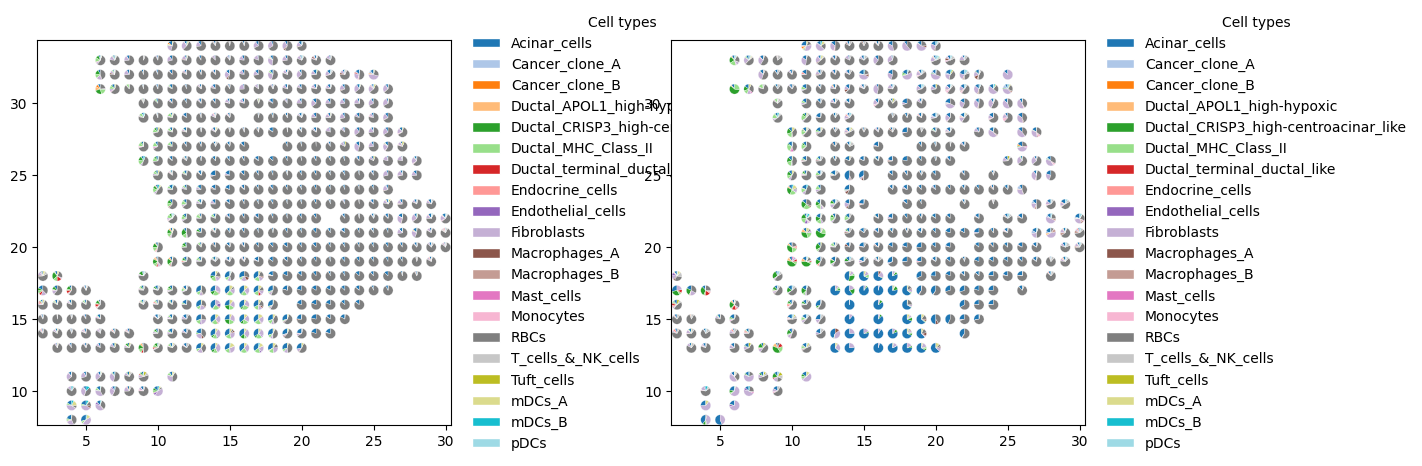

In [241]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)


scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)

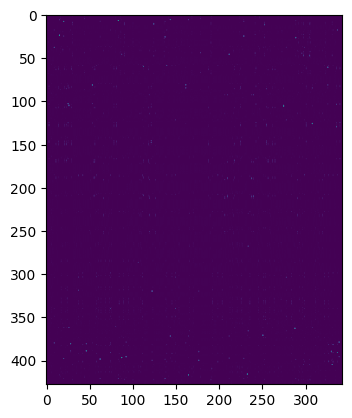

In [242]:
plt.imshow(pi[0])